**Variational Auto Encoders**

***Using the given dataset and model provided, must add two layers for encoder path and their corresponding two layers in the decoder path***

Importing the required libraries

In [63]:
#importing the libraries 
import keras
import tensorflow as tf
from keras.layers import Conv2D, Conv2DTranspose, Input, Flatten, Dense, Lambda, Reshape
from keras.layers import BatchNormalization
from keras.models import Model
from keras.datasets import mnist
from keras.losses import binary_crossentropy
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt

***Loading MNIST Dataset***:

The autoencoder will be trained using the MNIST dataset. Thousands of 28 × 28 pixel images of handwritten numerals make up this dataset. As a result, our autoencoder will learn how handwritten digits are distributed over (two)dimensional latent space, which we can then utilize to edit samples into the format we want.

In [64]:
#Loading the MNIST dataset
(input_train_1, target_train_1), (input_test_1, target_test_1) = mnist.load_data()

Depecting the training and test data and their shapes

In [65]:
#Depecting the training and test data and their shapes
print(input_train_1.shape)
print(input_train_1)
print(input_test_1.shape)
print(input_test_1)
print(target_train_1.shape)
print(target_train_1)
print(target_test_1.shape)
print(target_test_1)

(60000, 28, 28)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]
(10000, 28, 28)
[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...


***Reducing the Data Size:***

I reduced the data size here (training set is reduced from 60000 to 10000 images, and test set is reduced from 10000 to 1000 images) because the original data size was causing out of memory errors and requiring extra GPU.

In [66]:
#Reducing the size of the data
input_train=input_train_1[0:10000]
target_train=target_train_1[0:10000]
input_test=input_test_1[0:1000]
target_test=target_test_1[0:1000]

Printing the training and test data sizes

In [67]:
#Depicting the training and test data sizes
print(input_train.shape)
print(input_test.shape)
print(target_train.shape)
print(target_test.shape)

(10000, 28, 28)
(1000, 28, 28)
(10000,)
(1000,)


Printing first 20 images from the data set

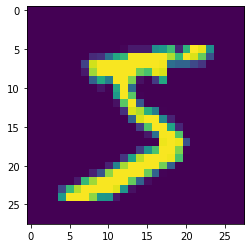

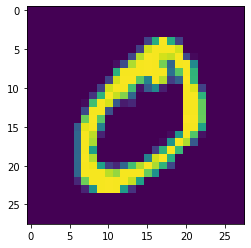

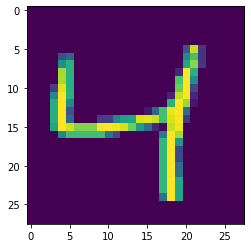

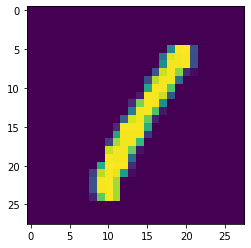

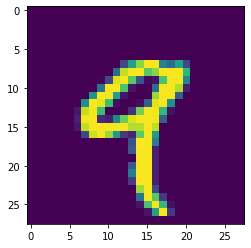

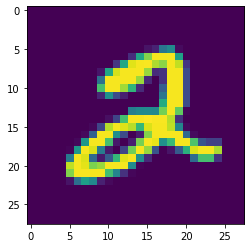

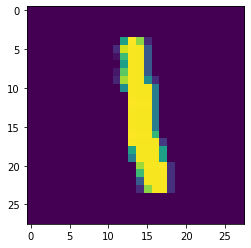

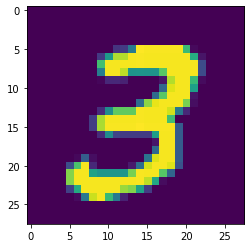

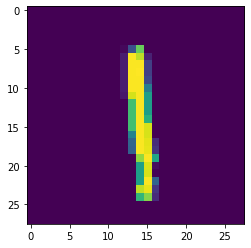

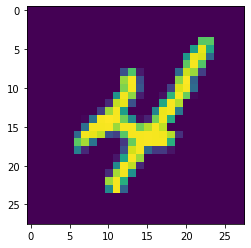

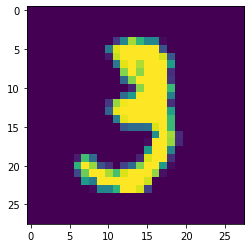

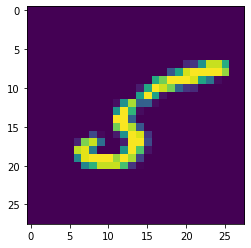

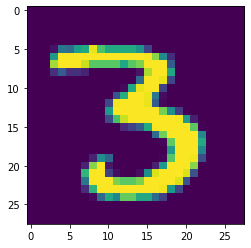

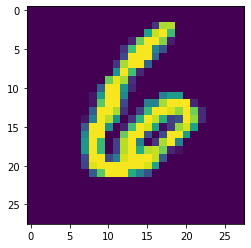

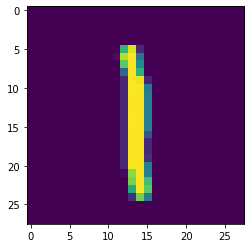

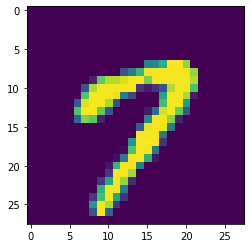

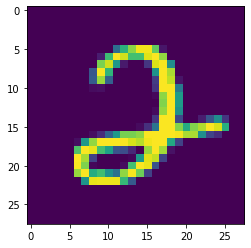

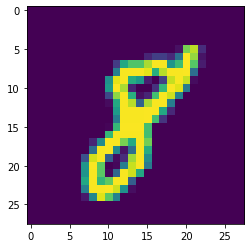

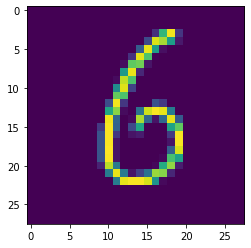

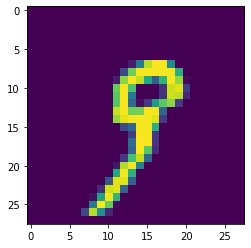

In [68]:
#Printing first 20 images from the dataset
for i in range(20):
  pr_image = input_train[i]
  pr_image = np.array(pr_image, dtype='float')
  pixels = pr_image.reshape((28, 28))
  plt.imshow(pixels)
  plt.show()

***Model configuration***: Setting config parameters for data and model.

The training data determines the breadth and height of our configuration settings. Because the MNIST dataset contains samples that are 28 x 28 pixels, we'll use img width = img height = 28.

The batch size is 128 samples per (mini)batch, which is standard. The same can be said for the number of epochs, which was set at 50. Validation is done with 20% of the training data. This is also a common occurrence. There's nothing exceptional about this place.

The verbosity mode is set to True (by 1), which implies that the entire output is displayed on the screen.

The latter two configuration options are of particular relevance. The latent space will initially be two-dimensional. Finally, the num_channels option can be set to the number of picture channels: 3 (red, green, blue) for RGB data, and 1 for grayscale data (such as MNIST).

In [69]:
#Setting configuration parameters for data and model
img_width = input_train.shape[1]
img_height = input_train.shape[2]
batch_size = 128
no_epochs = 50
validation_split = 0.2
verbosity = 1
latent_dim = 2
num_channels = 1

Next, we reshape the data so that it takes the shape (X, 28, 28, 1), where X is the number of samples in either the training or testing dataset. We also set (28, 28, 1) as input_shape.

Next, we parse the numbers as floats, which presumably speeds up the training process, and normalize it, which the neural network appreciates

In [70]:
# Reshape data
input_train = input_train.reshape(input_train.shape[0], img_height, img_width, num_channels)
input_test = input_test.reshape(input_test.shape[0], img_height, img_width, num_channels)
input_shape = (img_height, img_width, num_channels)

# Parse numbers as floats
input_train = input_train.astype('float32')
input_test = input_test.astype('float32')

# Normalize data
input_train = input_train / 255
input_test = input_test / 255

***Auto Encoder:***

Autoencoders are a specific type of feedforward neural networks where the input is the same as the output. 

They compress the input into a lower-dimensionalcodeand then reconstruct the output from this representation. 

To build an autoencoder  we need  3 things: an encoding method,  decoding method,  and a loss function to compare the output  with the target.

***Creating the encoder***

Now, it’s time to create the encoder. This is a three-step process: firstly, we define it. Secondly, we perform something that is known as the reparameterization trick in order to allow us to link the encoder to the decoder later, to instantiate the VAE as a whole. But before that, we instantiate the encoder first, as our third and final step.

***Encoder definition***

The first step in the three-step process is the definition of our encoder. Following the connection process of the Keras Functional API, we link the layers together

***Layers Description:***

The first layer is the **Input laye**r. It accepts data with input_shape = (28, 28, 1) and is named encoder_input.

Next up is a two-dimensional convolutional layer, or **Conv2D** in Keras terms. It learns 8 filters by deploying a 3 x 3 kernel which it convolves over the input. It has a stride of two which means that it skips over the input during the convolution as well, speeding up the learning process. It employs ‘same’ padding and ReLU activation. Do note that officially, it’s best to use He init with ReLU activating layers. However, since the dataset is relatively small, it shouldn’t be too much of a problem if you don’t.

Subsequently, we use **Batch Normalization**. This layer ensures that the outputs of the Conv2D layer that are input to the next Conv2D layer have a steady mean and variance, likely μ=0.0,σ=1.0 (plus some ϵ, an error term to ensure numerical stability). This benefits the learning process.

Once again, a Conv2D layer. It learns 16 filters and for the rest is equal to the first Conv2D layer.

BatchNormalization once more.

Next up, a **Flatten layer**, it only serves to flatten the multidimensional data from the convolutional layers into one-dimensional shape. This has to be done because the densely-connected layers that we use next require data to have this shape.

The next layer is a **Dense** layer with 20 output neurons. It’s the autoencoder bottleneck we’ve been talking about.

BatchNormalization once more.

The next two layers, mu and sigma, are actually not separate from each other – look at the previous layer they are linked to (both x, i.e. the Dense(20) layer). The first outputs the mean values μ of the encoded input and the second one outputs the stddevs σ. With these, we can sample the random variables that constitute the point in latent space onto which some input is mapped. That’s for the layers of our encoder.



In [71]:
# Definition of Encoder
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=2, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)
x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

The next step is to retrieve the shape of the final Conv2D output. We’ll need it when defining the layers of our decoder


In [72]:
# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

***Defining Sampling with reparameterization:***

If you use neural networks (or, to be more precise, gradient descent) for optimizing the variational autoencoder, you effectively minimize some expected loss value, which can be estimated with Monte-Carlo techniques (Huang, n.d.). However, this requires that the loss function is differentiable, which is not necessarily the case, because it is dependent on the parameter of some probability distribution that we don’t know about. In this case, it’s possible to rewrite the equation, but then it no longer has the form of an expectation, making it impossible to use the Monte-Carlo techniques usable before.

However, if we can reparameterize the sample fed to the function into the shape μ+σ2×ϵ, it now becomes possible to use gradient descent for estimating the gradients accurately (Gunderson, n.d.; Huang, n.d.).

And that’s precisely what we’ll do in our code. We “sample” the value for z from the computed μ and σ values by resampling into mu + K.exp(sigma / 2) * eps.

In [73]:
# Define sampling with reparameterization trick
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

We then use this with a Lambda to ensure that correct gradients are computed during the backwards pass based on our values for mu and sigma

In [74]:
# Use reparameterization trick to ensure correct gradient
z = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

***Encoder instantiation:***

Now, it’s time to instantiate the encoder – taking inputs through input layer i, and outputting the values generated by the mu, sigma and z layers (i.e., the individual means and standard deviations, and the point sampled from the random variable represented by them):

In [75]:
# Instantiate encoder
Encoder = Model(i, [mu, sigma, z], name='Encoder')
Encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_12 (Conv2D)             (None, 14, 14, 8)    80          ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization_32 (BatchN  (None, 14, 14, 8)   32          ['conv2d_12[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_13 (Conv2D)             (None, 7, 7, 16)     1168        ['batch_normalization_32[0]

***Decoder Definition:***

Creating the decoder is a bit simpler and boils down to a two-step process: defining it, and instantiating it.

***Layers Description:***

Our decoder also starts with an Input layer, the ***decoder_input*** layer. It takes input with the shape (latent_dim, ), which as we will see is the vector we sampled for z with our encoder.

If we’d like to upsample the point in latent space with **Conv2DTranspose** layers, in exactly the opposite symmetrical order as with we downsampled with our encoder, we must first bring back the data from shape (latent_dim, ) into some shape that can be reshaped into the output shape of the last convolutional layer of our encoder.

This is why you needed the conv_shape variable. We’ll thus now add a Dense layer which has conv_shape[1] * conv_shape[2] * conv_shape[3] output, and converts the latent space into many outputs.

We next use a Reshape layer to convert the output of the **Dense layer** into the output shape of the last convolutional layer: (conv_shape[1], conv_shape[2], conv_shape[3] = (7, 7, 16). Sixteen filters learnt with 7 x 7 pixels per filter.

We then use Conv2DTranspose and **BatchNormalization** in the exact opposite order as with our encoder to upsample our data into 28 x 28 pixels (which is equal to the width and height of our inputs). However, we still have 8 filters, so the shape so far is (28, 28, 8).

We therefore add a final Conv2DTranspose layer which does nothing to the width and height of the data, but ensures that the number of filters learns equals num_channels. For MNIST data, where num_channels = 1, this means that the shape of our output will be (28, 28, 1). This last layer also uses Sigmoid activation, which allows us to use binary crossentropy loss when computing the reconstruction loss part of our loss function.


In [76]:
# Decoder Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)
cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

***Decoder Instantiation:***

The next thing we do is instantiate the decoder

It takes the inputs from the decoder input layer d_i and outputs whatever is output by the output layer o.

In [77]:
# Instantiate decoder
Decoder = Model(d_i, o, name='Decoder')
Decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_9 (Dense)             (None, 784)               2352      
                                                                 
 batch_normalization_35 (Bat  (None, 784)              3136      
 chNormalization)                                                
                                                                 
 reshape_4 (Reshape)         (None, 7, 7, 16)          0         
                                                                 
 conv2d_transpose_12 (Conv2D  (None, 14, 14, 16)       2320      
 Transpose)                                                      
                                                                 
 batch_normalization_36 (Bat  (None, 14, 14, 16)       64  

***Instantiating VAE:***

Now that the encoder and decoder are complete, we can create the VAE(Variational Auto Encoder) as a whole.

The outputs of the entire VAE are the original inputs, encoded by the encoder, and decoded by the decoder.

That’s how we arrive at vae_outputs = decoder(encoder(i)[2]): inputs i are encoded by the encoder into [mu, sigma, z] (the individual means and standard deviations with the sampled z as well). We then take the sampled z values (hence the [2]) and feed it to the decoder, which ensures that we arrive at correct VAE output.

We then instantiate the model: i are our inputs indeed, and vae_outputs are the outputs. We call the model vae, because it simply is Variational Auto Encoder.



In [78]:
# Instantiate VAE
vae_outputs = Decoder(Encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        [(None, 2),               17208     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         9137      
                                                                 
Total params: 26,345
Trainable params: 24,641
Non-trainable params: 1,704
_________________________________________________________________


***Compilation & training:***

we can compile our model. We do so using the Adam optimizer and binary crossentropy loss function.

tf.config.run_functions_eagerly(True) is added to overcome the vae.fit error with colab, you may not need it if you are running the code in pycharm or jupyter notebooks.

In [79]:
tf.config.run_functions_eagerly(True)
# Compile VAE
vae.compile(optimizer='adam', loss='binary_crossentropy')

# Train autoencoder
vae.fit(input_train, input_train, epochs = no_epochs, batch_size = batch_size, validation_split = validation_split)

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


63/63 [==============================] - 5s 82ms/step - loss: 0.6606 - val_loss: 0.5633
Epoch 2/50
63/63 [==============================] - 5s 84ms/step - loss: 0.4264 - val_loss: 0.4008
Epoch 3/50
63/63 [==============================] - 5s 83ms/step - loss: 0.2869 - val_loss: 0.3563
Epoch 4/50
63/63 [==============================] - 5s 83ms/step - loss: 0.2492 - val_loss: 0.3299
Epoch 5/50
63/63 [==============================] - 5s 81ms/step - loss: 0.2366 - val_loss: 0.3022
Epoch 6/50
63/63 [==============================] - 5s 87ms/step - loss: 0.2289 - val_loss: 0.2761
Epoch 7/50
63/63 [==============================] - 5s 82ms/step - loss: 0.2228 - val_loss: 0.2591
Epoch 8/50
63/63 [==============================] - 5s 87ms/step - loss: 0.2199 - val_loss: 0.2397
Epoch 9/50
63/63 [==============================] - 5s 87ms/step - loss: 0.2169 - val_loss: 0.2351
Epoch 10/50
63/63 [==============================] - 5s 85ms/step - loss: 0.2140 - val_loss: 0.2247
Epoch 11/50
63/63 [=

Results Visualization

In [80]:
#Results Visualization
def viz_latent_space(encoder, data):
  input_data, target_data = data
  mu, _, _ = encoder.predict(input_data)
  plt.figure(figsize=(8, 10))
  plt.scatter(mu[:, 0], mu[:, 1], c=target_data)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  plt.colorbar()
  plt.show()

In [81]:
def viz_decoded(encoder, decoder, data):
  num_samples = 15
  figure = np.zeros((img_width * num_samples, img_height * num_samples, num_channels))
  grid_x = np.linspace(-4, 4, num_samples)
  grid_y = np.linspace(-4, 4, num_samples)[::-1]
  for i, yi in enumerate(grid_y):
      for j, xi in enumerate(grid_x):
          z_sample = np.array([[xi, yi]])
          x_decoded = decoder.predict(z_sample)
          digit = x_decoded[0].reshape(img_width, img_height, num_channels)
          figure[i * img_width: (i + 1) * img_width,
                  j * img_height: (j + 1) * img_height] = digit
  plt.figure(figsize=(10, 10))
  start_range = img_width // 2
  end_range = num_samples * img_width + start_range + 1
  pixel_range = np.arange(start_range, end_range, img_width)
  sample_range_x = np.round(grid_x, 1)
  sample_range_y = np.round(grid_y, 1)
  plt.xticks(pixel_range, sample_range_x)
  plt.yticks(pixel_range, sample_range_y)
  plt.xlabel('z - dim 1')
  plt.ylabel('z - dim 2')
  # matplotlib.pyplot.imshow() needs a 2D array, or a 3D array with the third dimension being of shape 3 or 4!
  # So reshape if necessary
  fig_shape = np.shape(figure)
  if fig_shape[2] == 1:
    figure = figure.reshape((fig_shape[0], fig_shape[1]))
  # Show image
  plt.imshow(figure)
  plt.show()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


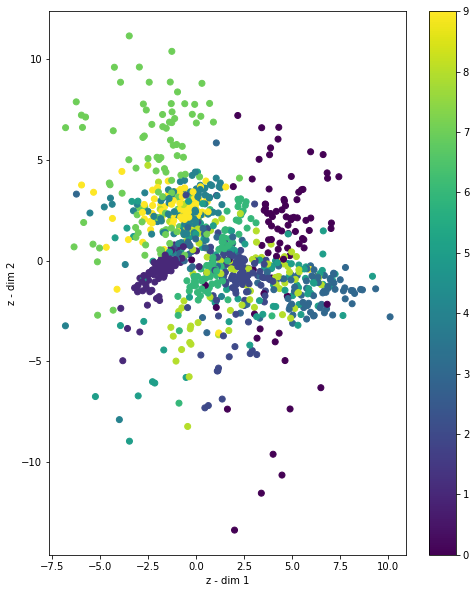

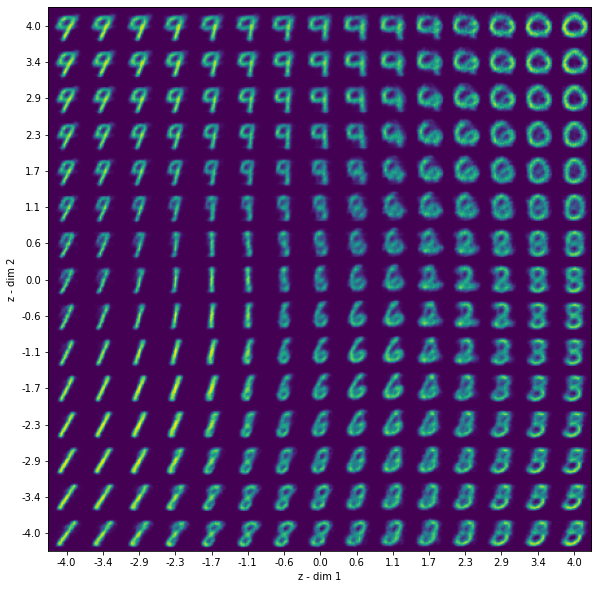

In [82]:
# Plot results
data = (input_test, target_test)
viz_latent_space(Encoder, data)
viz_decoded(Encoder, Decoder, data)

***Model 2:***

**Encoder Definition:**

I have added two layers. They are Conv2d and BatchNormalization layers with filters 32, 64 for Conv 2D

Also I have reduced number of strides from 2 to 1 in order to reduce the loss



In [83]:
# Encoder Definition
i       = Input(shape=input_shape, name='encoder_input')
cx      = Conv2D(filters=8, kernel_size=3, strides=1, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=16, kernel_size=3, strides=1, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)

cx      = Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu')(i)
cx      = BatchNormalization()(cx)
cx      = Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu')(cx)
cx      = BatchNormalization()(cx)


x       = Flatten()(cx)
x       = Dense(20, activation='relu')(x)
x       = BatchNormalization()(x)
mu      = Dense(latent_dim, name='latent_mu')(x)
sigma   = Dense(latent_dim, name='latent_sigma')(x)

In [84]:
# Get Conv2D shape for Conv2DTranspose operation in decoder
conv_shape = K.int_shape(cx)

In [85]:
# Define sampling with reparameterization trick
def sample_z(args):
  mu, sigma = args
  batch     = K.shape(mu)[0]
  dim       = K.int_shape(mu)[1]
  eps       = K.random_normal(shape=(batch, dim))
  return mu + K.exp(sigma / 2) * eps

In [86]:
# Use reparameterization trick to ensure correct gradient
z       = Lambda(sample_z, output_shape=(latent_dim, ), name='z')([mu, sigma])

In [87]:
# Instantiate encoder
Encoder = Model(i, [mu, sigma, z], name='Encoder')
Encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 encoder_input (InputLayer)     [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_16 (Conv2D)             (None, 28, 28, 32)   320         ['encoder_input[0][0]']          
                                                                                                  
 batch_normalization_40 (BatchN  (None, 28, 28, 32)  128         ['conv2d_16[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 conv2d_17 (Conv2D)             (None, 28, 28, 64)   18496       ['batch_normalization_40[0]

***Decoder Definition:***

In the same way as in encoder, I have added 2 Conv2DTranspose and 2 BatchNormalization layers with 32 and 64 for Conv2D layers

Also, reduced the number of strides from 2 to 1 for two layers in Conv2d with filters of 8 and 16.

In [88]:
#Decoder Definition
d_i   = Input(shape=(latent_dim, ), name='decoder_input')
x     = Dense(conv_shape[1] * conv_shape[2] * conv_shape[3], activation='relu')(d_i)
x     = BatchNormalization()(x)
x     = Reshape((conv_shape[1], conv_shape[2], conv_shape[3]))(x)

cx    = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)

cx    = Conv2DTranspose(filters=16, kernel_size=3, strides=1, padding='same', activation='relu')(x)
cx    = BatchNormalization()(cx)
cx    = Conv2DTranspose(filters=8, kernel_size=3, strides=1, padding='same',  activation='relu')(cx)
cx    = BatchNormalization()(cx)
o     = Conv2DTranspose(filters=num_channels, kernel_size=3, activation='sigmoid', padding='same', name='decoder_output')(cx)

Instantiating the decoder

In [89]:
# Instantiate decoder
Decoder = Model(d_i, o, name='Decoder')
Decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 decoder_input (InputLayer)  [(None, 2)]               0         
                                                                 
 dense_11 (Dense)            (None, 50176)             150528    
                                                                 
 batch_normalization_43 (Bat  (None, 50176)            200704    
 chNormalization)                                                
                                                                 
 reshape_5 (Reshape)         (None, 28, 28, 64)        0         
                                                                 
 conv2d_transpose_16 (Conv2D  (None, 28, 28, 16)       9232      
 Transpose)                                                      
                                                                 
 batch_normalization_46 (Bat  (None, 28, 28, 16)       64  

Instantiating VAE

In [90]:
# Instantiate VAE
vae_outputs = Decoder(Encoder(i)[2])
vae         = Model(i, vae_outputs, name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 Encoder (Functional)        [(None, 2),               1022904   
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 Decoder (Functional)        (None, 28, 28, 1)         361793    
                                                                 
Total params: 1,384,697
Trainable params: 1,284,065
Non-trainable params: 100,632
_________________________________________________________________


***Compiling & Training:***

Compiling the model with optimizer "adam" and I have changed number of epochs from 50 to 100 and loss function used is "binary_crossentropy"

We can see that loss has reduced from 0.1877 to 0.1701

In [91]:
tf.config.run_functions_eagerly(True)
# Compile VAE
vae.compile(optimizer='adam', loss='binary_crossentropy')

# Train autoencoder
vae.fit(input_train, input_train, epochs = 100, batch_size = batch_size, validation_split = validation_split)

Epoch 1/100


/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


63/63 [==============================] - 6s 99ms/step - loss: 0.5064 - val_loss: 0.4802
Epoch 2/100
63/63 [==============================] - 6s 94ms/step - loss: 0.2974 - val_loss: 0.3937
Epoch 3/100
63/63 [==============================] - 6s 94ms/step - loss: 0.2308 - val_loss: 0.4496
Epoch 4/100
63/63 [==============================] - 6s 93ms/step - loss: 0.2139 - val_loss: 0.4827
Epoch 5/100
63/63 [==============================] - 6s 97ms/step - loss: 0.2051 - val_loss: 0.4343
Epoch 6/100
63/63 [==============================] - 6s 95ms/step - loss: 0.2005 - val_loss: 0.3587
Epoch 7/100
63/63 [==============================] - 6s 95ms/step - loss: 0.1970 - val_loss: 0.2890
Epoch 8/100
63/63 [==============================] - 6s 96ms/step - loss: 0.1944 - val_loss: 0.2440
Epoch 9/100
63/63 [==============================] - 6s 99ms/step - loss: 0.1923 - val_loss: 0.3006
Epoch 10/100
63/63 [==============================] - 6s 93ms/step - loss: 0.1911 - val_loss: 0.2159
Epoch 11/10

***Plotting the results***

We can see that results which are numbers are seen correctly without any ambiguity for the model we have built

/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


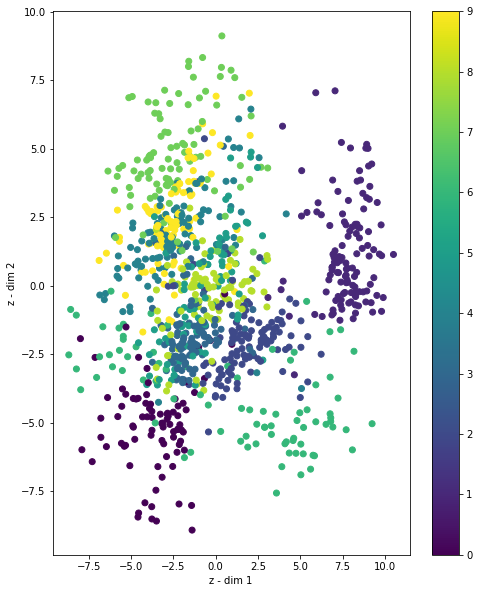

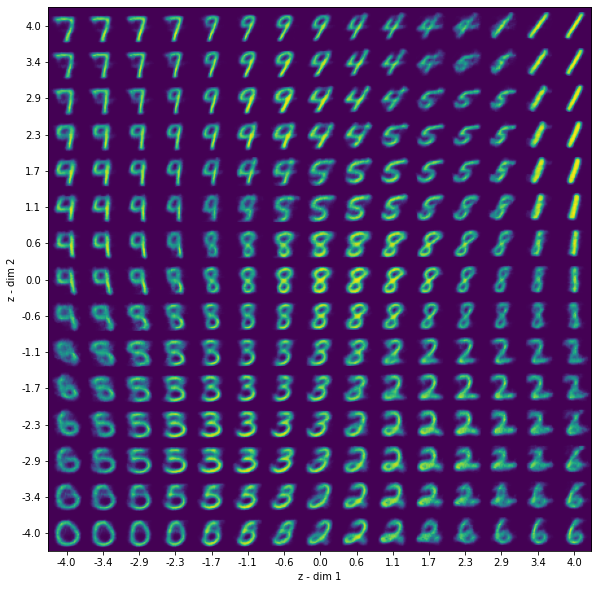

In [92]:
#Plot results
data = (input_test, target_test)
viz_latent_space(Encoder, data)
viz_decoded(Encoder, Decoder, data)